# Project resolution of optical dataset onto microwave dataset

## Load data

In [78]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio
import gdal

%matplotlib inline

In [44]:
#mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
#opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

opt_path_out = r"../Data/optical-rs/optical-cropped/"
# more paths needed

In [46]:
#data_mw = dataset_mw["melt"]
data_opt = xarray.open_dataarray(opt_path)
# put stuff to propper folder

In [47]:
# make new script to convert to tif and store separately?
data_mw.rio.to_raster("data_mw.tif")
# data_omw_tif = xarray.open_dataarray("data_mw.tif")
# data_omw_tif

## Reproject/ resample using rasterio

### Change resolution through rio.reproject_match

In [50]:
# look at metadata and min max before reprojecting
print('OPT')
with rasterio.open(opt_path) as src_opt:
        print(src_opt.meta)
        tt= src_opt.read()
        print(f'min:{tt.min()}')
        print(f'max:{tt.max()}')

print('MW')
with rasterio.open('data_mw.tif') as src_mw:
        print(src_mw.meta)
        mw = src_mw.read()
        print(f'min:{mw.min()}')
        print(f'max:{mw.max()}') 

        # In new script:
        #np.nan_to_num(mw, nan=-1, copy= False) # inplace 
        #kwargs1 = src_mw.meta.copy()

# # overwrite mw with fixed band
# with rasterio.open('data_mw.tif', 'w', **kwargs1) as dst:
#     dst.write_band(1, mw[0])

OPT
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1487, 'height': 2687, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(1000.0, 0.0, -637000.0,
       0.0, -1000.0, -662000.0)}
min:-3.4028234663852886e+38
max:4.195837497711182


In [52]:
# open data_mw.tif again?
data_mw_tif = xarray.open_dataarray("data_mw.tif")
# remove previous open if its unused

# check
np.unique(data_mw_tif)

In [54]:
# do thiiis before reprojecting???:

In [55]:
data_mw_tif['x'] = [i+500 for i in data_mw_tif['x']]
data_mw_tif['y'] = [i-500 for i in data_mw_tif['y']]
# maybe no need bc rio.reproject_match will reproject to match the resolution, projection, AND REGION of another raster.

In [56]:
print('before reprojection:')
print(np.unique(data_mw_tif, return_counts=True))


before reprojection:
(array([-1.,  0.,  1.], dtype=float32), array([2860, 3322,  358]))


##### Reprojection:

In [57]:
data_repr_mw = data_mw_tif.rio.reproject_match(data_opt) # raster to match in parenth - try make mw to opt resolution (but not scale so opt scale shouldn't impact?)
# before data_mw.rio....
#print("Reprojected Raster:\n-------------------")
#print_raster(data_repr_mw)

In [58]:
print('after reprojection:')
print(np.unique(data_repr_mw, return_counts=True))

# need to replace again???

after reprojection:
(array([-1.0000000e+00,  0.0000000e+00,  1.0000000e+00,  3.4028235e+38],
      dtype=float32), array([1666875, 2057725,  222500,   48469]))


In [59]:
#temp test put large/ nan to 2 and see if its just corners if yes - cut and done


#data_repr_mw[0][data_repr_mw[0] > 1] = 2
max_val = data_repr_mw.max()
#adata_repr_mw = np.where(data_repr_mw==max_val, 2, data_repr_mw) # bad bc turns to normal array
bdata_repr_mw = xarray.where(data_repr_mw!=max_val, data_repr_mw,  2)
#bdata_repr_mw = xarray.DataArray.where(data_repr_mw!=max_val, other = 2, drop = True)


In [60]:
type(bdata_repr_mw)

xarray.core.dataarray.DataArray

In [61]:
np.unique(bdata_repr_mw)

array([-1.,  0.,  1.,  2.], dtype=float32)

In [62]:
a = np.random.randint(0, 5, size=(5, 4))
a

array([[0, 3, 0, 1],
       [2, 2, 3, 3],
       [2, 1, 3, 2],
       [2, 2, 2, 0],
       [1, 0, 0, 1]])

In [63]:
a = np.where(a==-101, 55, a)


In [64]:
a

array([[0, 3, 0, 1],
       [2, 2, 3, 3],
       [2, 1, 3, 2],
       [2, 2, 2, 0],
       [1, 0, 0, 1]])

In [65]:
print("more info")

#print("before:\n----------------")
#print_raster(data_mw_tif)
print("after:\n----------------")
print_raster(data_repr_mw)
print("opt:\n----------------")
print_raster(data_opt)

more info
after:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: inf
CRS: EPSG:3413

opt:
----------------


/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/RP_Greenland/RP_Greenland/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



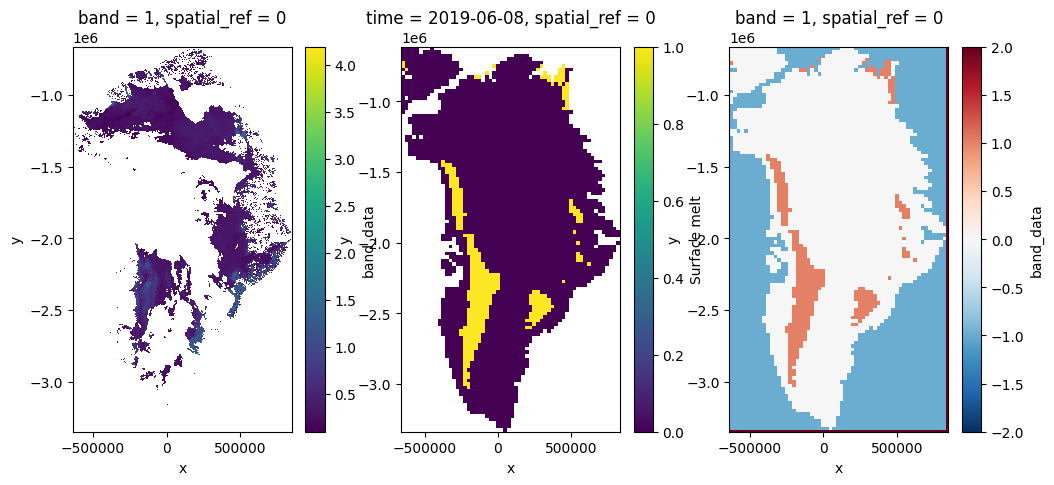

In [45]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
data_opt.plot(ax=axes[0])
data_mw.plot(ax=axes[1])
bdata_repr_mw.plot(ax=axes[2])
plt.draw()
# need to fix scale and nans!!!